# ScotRail Announcements Exploration
"Bizarre FOI find of the day: Scotrail has openly published a two-hour long sound file containing every single element of its automated station announcements (link to file)" -- [@jonbradyphoto](https://twitter.com/jonbradyphoto/status/1560630522002321408)

"If anyone needs this split into 2,440 individual mp3s - because why wouldn't you - I've put them here: https://drive.google.com/drive/folders/172W6sXnvlr7UcNLipO8BTw417_KRz9c5?usp=sharing

And if anyone wants to help transcribe all the files, here's a shared sheet, which has a good chance of descending into chaos" -- [@MattEason](https://twitter.com/MattEason/status/1560653413783744512)


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

## ScotRail Announcements
Quick attempt to split the 2hr long mp3 file into separate announcements (see 2022-08-20).

In [3]:
import sox
from scipy.ndimage import minimum_filter1d
from IPython.display import Audio

In [4]:
data_dir = os.path.expanduser('~/Work/Data/ScotRail')
sound_file = os.path.join(data_dir, 'ScotRail_Station_Announcements_June2022.mp3')

In [5]:
tfm = sox.Transformer()
announcements = tfm.build_array(sound_file)

In [6]:
sr = sox.file_info.sample_rate(sound_file)
print(f'Sample rate is {sr}')

Sample rate is 16000.0


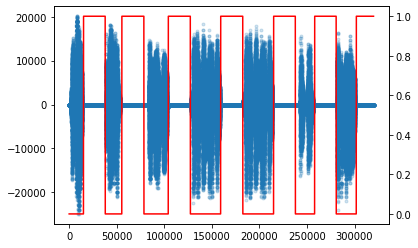

In [7]:
window = int(20*sr)
start = int(0*sr)
sample = announcements[start:start+window]
silence = np.where(sample == -8, 1, 0)
fig, ax = plt.subplots()
ax_r = ax.twinx()
_ = ax.plot(sample, linestyle='none', marker='.', alpha=0.2)
# _ = ax_r.plot(silence, c='r')
# _ = ax_r.plot(np.diff(silence), c='g')
_ = ax_r.plot(minimum_filter1d(silence, size=800), c='r')

In [8]:
def get_silences(signal, window_size=8000):
    """Return indexes of periods of silence start and end 
    Default window size is 0.5s i.e. a silence needs to be at least this long
    to be counted
    """
    silence = minimum_filter1d(np.where(signal == -8, 1, 0), size=window_size)
    silence_change = np.diff(silence)
    silence_start = np.where(silence_change == 1)[0]
    silence_end = np.where(silence_change == -1)[0]
    return silence_start, silence_end

In [9]:
silence_start, silence_end = get_silences(announcements)

In [10]:
print(silence_start.shape, silence_end.shape)

(2439,) (2439,)


In [11]:
def create_metadata(announcements, sr, silence_start, silence_end):
    df_announcements = pd.DataFrame(
        np.vstack(
            [np.concatenate([[0], silence_end]), 
             np.concatenate([silence_start, [len(announcements)]])
            ]).T.tolist(),
        columns=['start_ind', 'end_ind']
    ).assign(
        length_samples=lambda x: (x['end_ind'] - x['start_ind']), 
        length_sec=lambda x: x['length_samples']/sr
    )
    return df_announcements

df_announcements = create_metadata(announcements, sr, silence_start, silence_end)

df_announcements.head()

,start_ind,end_ind,length_samples,length_sec
0,0,18615,18615,1.163437
1,34243,58911,24668,1.541750
2,74919,107749,32830,2.051875
3,123749,162823,39074,2.442125
4,178884,218484,39600,2.475000


In [12]:
df_announcements.tail()

,start_ind,end_ind,length_samples,length_sec
2435,121181445,121211776,30331,1.895687
2436,121227565,121252765,25200,1.575000
2437,121268472,121293500,25028,1.564250
2438,121309682,121334140,24458,1.528625
2439,121350196,121364928,14732,0.920750


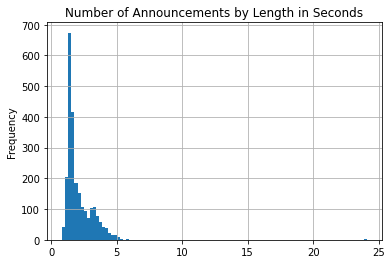

In [13]:
_ = df_announcements.length_sec.plot(
    kind='hist', bins=100, grid=True,
    title='Number of Announcements by Length in Seconds', 
)

In [14]:
df_announcements.describe()

,start_ind,end_ind,length_samples,length_sec
count,2.440000e+03,2.440000e+03,2440.000000,2440.000000
mean,6.442420e+07,6.445795e+07,33749.847951,2.109365
std,3.568373e+07,3.567845e+07,16215.842027,1.013490
min,0.000000e+00,1.861500e+04,13672.000000,0.854500
25%,3.229508e+07,3.231840e+07,23365.250000,1.460328
50%,6.945605e+07,6.947936e+07,26847.500000,1.677969
75%,9.561845e+07,9.564293e+07,41794.250000,2.612141
max,1.213502e+08,1.213649e+08,385268.000000,24.079250


In [15]:
df_announcements.length_sec.quantile([0.05, 0.5, 0.99])

0.05    1.213803
0.50    1.677969
0.99    4.875538
Name: length_sec, dtype: float64

Interesting distribution of announcements - the overall count looks about right, would be nice to understand the couple of long announcements.  

In [16]:
df_announcements.loc[4, ['start_ind', 'end_ind']].astype(int).to_list()

[178884, 218484]

In [17]:
def get_announcement(ind, sound_array=None, df=None):
    start_ind, end_ind = df.loc[ind, ['start_ind', 'end_ind']].astype(int).to_list()
    signal = sound_array[start_ind:end_ind]
    return signal

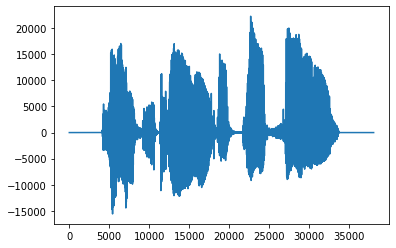

In [18]:
_ = plt.plot(get_announcement(10, announcements, df_announcements))

In [19]:
Audio(get_announcement(0, announcements, df_announcements), rate=sr, autoplay=True)

Looks like getting the individual announcements is working, as is playing using Jupyter Audio.  Now, what are the
long announcements?

In [20]:
df_announcements.loc[df_announcements.length_sec > 6, :]

,start_ind,end_ind,length_samples,length_sec
160,9526355,9911623,385268,24.07925


'Attention please: here is a special announcement.  Penalty fares are in operation in this area.  All passengers must be in posession of a valid ticket or authority to travel before traveling on services from this station.  
'If you are asked to produce a ticket and are unable to do so you will be liable to pay a penalty fare ore the full standard single fare, whichever is greater'

NB: originally I used a silence window of 0.05s that resulted in this being split into two announcements, and made the mapping with crowdsourced annotations disagree.  Increasing the window to 0.5s seems to have fixed things.

In [21]:
Audio(get_announcement(160, announcements, df_announcements), rate=sr, autoplay=True)

Wrap this all up in an object for ease of use

In [22]:
class ScotRailAnnouncements:
    def __init__(self, sound_file=None, sound_array=None, sample_rate=None, metadata=None, window_size=None):
        tfm = sox.Transformer()
        self.announcements = sound_array if (sound_array is not None) else tfm.build_array(sound_file)
        self.sr = sample_rate or sox.file_info.sample_rate(sound_file)
        self.df_meta = (
            metadata if (metadata is not None) else 
            create_metadata(self.announcements, self.sr, *get_silences(announcements, window_size=window)))
        self.auto_play = False
        
    def get(self, ind):
        return get_announcement(ind, self.announcements, self.df_meta)
    
    def play(self, ind):
        _ = plt.plot(self.get(ind))
        return Audio(self.get(ind), rate=self.sr, autoplay=self.auto_play)

In [23]:
# scot_rail = ScotRailAnnouncements(sound_file)   # Load file and process
scot_rail = ScotRailAnnouncements(
    sound_array=announcements, sample_rate=sr, metadata=df_announcements
)   # Use already loaded

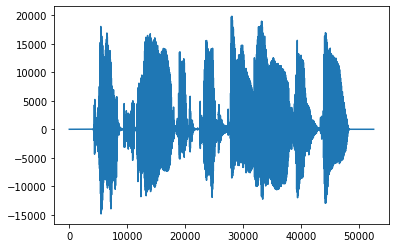

In [24]:
scot_rail.play(11)

In [25]:
scot_rail.df_meta.sort_values('length_sec').head(10)

,start_ind,end_ind,length_samples,length_sec
1392,76134319,76147991,13672,0.854500
735,37754391,37768415,14024,0.876500
1393,76163802,76177868,14066,0.879125
2439,121350196,121364928,14732,0.920750
1405,76592450,76607427,14977,0.936063
1170,67263382,67278535,15153,0.947063
1387,75954001,75969420,15419,0.963688
536,28306639,28322161,15522,0.970125
1243,70407806,70423485,15679,0.979938
1389,76025906,76041653,15747,0.984187


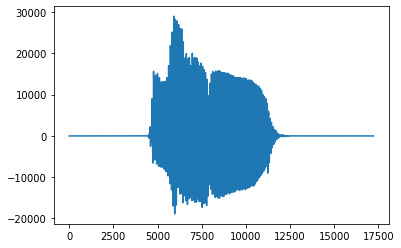

In [26]:
# Ooh - numbers from 1 to 10 are from ind 1162 to 1172
scot_rail.play(1162)

# Combining with crowd sourced transcriptions
This uses the Google Sheet mentioned in @MattEason's tweet exported as csv

In [27]:
df_l = pd.read_csv(os.path.join(data_dir, 'ScotRail announcements June 2022 index  - Index.csv'))

In [28]:
scot_rail.df_meta['transcription'] = df_l.Transcription
scot_rail.df_meta['transcription_length'] = df_l.Transcription.str.len()

In [29]:
def play_with_transcription(ind):
    audio = scot_rail.play(ind)
    _ = plt.title(f'{ind}: {scot_rail.df_meta["transcription"][ind]}')
    return audio

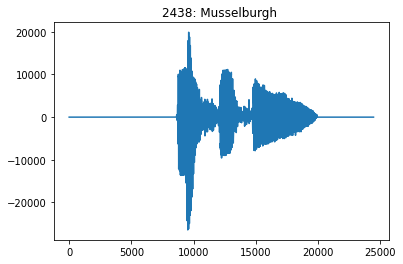

In [30]:
play_with_transcription(2438)

A very rough attempt at extracting a vocabulary

In [31]:
from collections import Counter

In [32]:
vocab = Counter(
    (' '.join(
        scot_rail.df_meta.transcription.str.replace('\W', ' ', regex=True).str.lower().str.strip().to_list())
    ).split(' ')
)

In [33]:
vocab.most_common()[:20]

[('the', 431),
 ('a', 339),
 ('train', 286),
 ('this', 192),
 ('of', 179),
 ('earlier', 173),
 ('on', 148),
 ('today', 113),
 ('in', 105),
 ('to', 103),
 ('is', 101),
 ('platform', 92),
 ('at', 85),
 ('please', 83),
 ('railway', 83),
 ('will', 77),
 ('service', 75),
 ('', 72),
 ('be', 60),
 ('minutes', 59)]

In [34]:
vocab.most_common()[-20:]

[('ardossan', 1),
 ('atterdale', 1),
 ('garelochhead', 1),
 ('kildonnan', 1),
 ('penzance', 1),
 ('moss', 1),
 ('scottstounhill', 1),
 ('brancherton', 1),
 ('breech', 1),
 ('kidross', 1),
 ('hall', 1),
 ('attadale', 1),
 ('gairlochead', 1),
 ('kildonan', 1),
 ('lochailort', 1),
 ('mosspark', 1),
 ('queens', 1),
 ('scotstounhill', 1),
 ('cardross', 1),
 ('thorntonhall', 1)]

In [35]:
len(vocab)

1264

In [36]:
def lookup_phrase(df_m, phrase):
    return df_m.index[df_m.transcription.str.lower().str.contains(phrase.lower())]

In [37]:
lookup_phrase(scot_rail.df_meta, 'Platform')

Int64Index([   0,   10,   11,   12,   13,   14,   15,   16,   17,   18,   19,
              20,   21,   22,   23,   24,   25,   26,   34,   35,   37,   38,
              39,   40,   41,   42,   43,   44,   53,   54,   55,   56,   57,
              58,   59,   60,   67,   68,   69,   70,   71,   72,   73,   74,
              75,   76,   77,   78,   79,   80,   81,   85,   86,   87,   88,
              89,   90,   91,   92,  189,  190,  191,  192,  193,  194,  195,
             196,  228,  382,  383,  384,  385,  486,  550,  552,  554,  556,
            1270, 1511, 1513, 1515, 1517, 1563, 1678, 1726, 1750, 1961, 1962,
            1963, 1964, 1965, 1966, 1967, 1968],
           dtype='int64')

In [38]:
lookup_phrase(scot_rail.df_meta, '11')

Int64Index([62, 125, 186, 247, 323], dtype='int64')

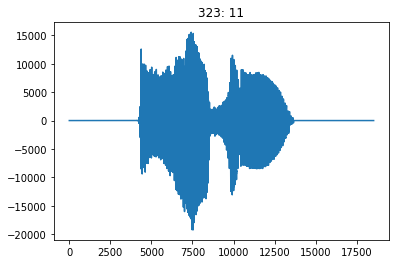

In [39]:
play_with_transcription(323)

In [48]:
lookup_phrase(scot_rail.df_meta, 'glasgow')

Int64Index([263, 264, 410, 411, 724, 725, 1846, 1847, 2102, 2326], dtype='int64')

In [43]:
scot_rail.auto_play = True

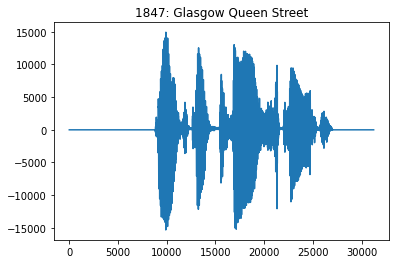

In [56]:
play_with_transcription(1847)